In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
db = sqlite3.connect('../labeled_media.db')
query = "SELECT mediaobject.caption, mediaobject.comment_ratio, mediaobject.like_ratio, mediaobject.mentions, mediaobject.quality, user.follower, user.following, user.posts FROM mediaobject INNER JOIN user ON mediaobject.user_id=user.user_id WHERE mediaobject.quality IS NOT NULL"
data = pd.read_sql_query(query, db)
data = data.dropna()

In [3]:
data.head()

,caption,comment_ratio,like_ratio,mentions,quality,follower,following,posts
0,Street art Barcelona unknown artists #art #str...,0.000000,0.014158,0,1,4585,335,745
1,Street art Barcelona unknown artist. #streetar...,0.000436,0.020693,0,0,4585,335,745
2,By @nilbartolozzi #packaging #design,0.000871,0.016336,1,0,4585,335,745
3,By @richartshields #illustration #pen,0.000218,0.023524,1,1,4585,335,745
4,By @guccibeauty #gucci #beauty,0.000000,0.007188,1,0,4585,335,745


In [4]:
data['quality'].value_counts()

0    2109
1     855
Name: quality, dtype: int64

In [5]:
high_quality = len(data[data['quality']==1.0])
low_quality = len(data[data['quality']==0.0])
print("High Quality images: %f%%" % ((high_quality/len(data))*100))
print("Low Quality images: %f%%" % ((low_quality/len(data))*100))

High Quality images: 28.846154%
Low Quality images: 71.153846%


The dataset seems unbalanced, therefore either down- or upsample the dataset.

In [6]:
count_low, count_high = data['quality'].value_counts()
low_quality = data[data['quality'] == 0]
high_quality = data[data['quality'] == 1]

low_quality_under = low_quality.sample(count_high)

data = pd.concat([low_quality_under, high_quality], axis=0)

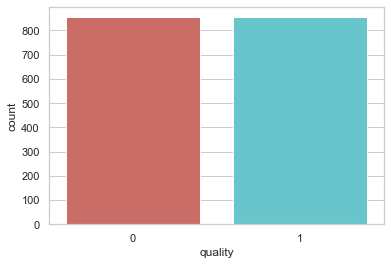

In [7]:
sns.countplot(x='quality',data=data, palette='hls')
plt.show()

In [8]:
data.groupby('quality').mean()

,comment_ratio,like_ratio,mentions,follower,following,posts
quality,,,,,,
0,0.001873,0.037569,1.264327,807131.647953,1024.022222,2080.520468
1,0.001042,0.044336,1.353216,655943.563743,1035.254971,2258.801170


# Feature Selection

In [9]:
# Average word length
# Take the sum of the length of all the words and divide it by the total length of the tweet
def avgword(sentence):
    words = sentence.split()
    if len(words) > 0:
        return (sum(len(word) for word in words)/len(words))
    else:
        return 0.0

In [10]:
# Add num of hashtags and caption length
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

hashtags = []
hashtags_num = []
wordcount = []
charcount = []
clean_caption = []
avgword_length = []
for caption in data['caption']:
    # find hashtags
    tags = re.findall(r'(?<=[\s>])#(\d*[A-Za-z_]+\d*)\b(?!;)', caption)
    
    # delete mentions and hashtags
    cc = re.sub(r'(#\w+)', '', caption)
    cc = re.sub(r'@[A-Za-z0-9]+', '', cc)
    cc = cc.strip().lower()
    clean_caption.append(cc)
    
    # Number of chars and words
    charcount.append(len(cc))
    wordcount.append(len(cc.split()))
    
    # Avg word length
    avgword_length.append(avgword(cc))
    
    # hashtags
    hashtags_num.append(len(tags))
    hashtags.append(' '.join(tags))

data['hashtags'] = hashtags
data['hashtags_num'] = hashtags_num
data['wordcount'] = wordcount
data['charcount'] = charcount
data['avgword'] = avgword_length
data['clean_caption'] = clean_caption
data['clean_caption'] = data['clean_caption'].fillna('')

num_feature_cols = ['quality', 'mentions', 'like_ratio', 'comment_ratio', 'hashtags_num', 'wordcount', 'charcount', 'avgword', 'follower', 'following', 'posts']
data_final = data[num_feature_cols]

# Vectorizing Hashtags and Caption

In [62]:
# Vectorizing the caption
vectorizer = TfidfVectorizer(stop_words='english')

vectorized_caption = vectorizer.fit_transform(data['clean_caption']).todense()
vectorized_hashtags = vectorizer.fit_transform(data['hashtags']).todense()

# Logistic Regression Training

In [63]:
# Features without quality column
num_features = data[num_feature_cols].iloc[:, 1:].values
X = np.hstack((vectorized_caption, vectorized_hashtags, num_features))
y = data.quality

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
import sklearn.preprocessing


# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [65]:
#model = KNeighborsClassifier()
#model = LinearDiscriminantAnalysis()
#model = DecisionTreeClassifier()

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Gaussian Process"]

classifiers = [
    KNeighborsClassifier(3),
    #LinearDiscriminantAnalysis(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
]

In [66]:
from sklearn import metrics


for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    score = clf.score(X_test, y_test)
    cnf_matrix = metrics.confusion_matrix(y_test, predictions)
    
    print(metrics.classification_report(y_test,predictions))
    print(cnf_matrix)
    print("Accuracy:", metrics.accuracy_score(y_test, predictions))
    print("Precision:", metrics.precision_score(y_test, predictions))
    print("Recall:", metrics.recall_score(y_test, predictions))
    print("Score: ", score)
    print()
    print(metrics.matthews_corrcoef(y_test, predictions))
    print()
    print("------------------------------------")
    print()

Nearest Neighbors
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       213
           1       0.67      0.71      0.69       215

    accuracy                           0.68       428
   macro avg       0.68      0.68      0.68       428
weighted avg       0.68      0.68      0.68       428

[[138  75]
 [ 63 152]]
Accuracy: 0.677570093457944
Precision: 0.6696035242290749
Recall: 0.7069767441860465
Score:  0.677570093457944

0.3555167779966022

------------------------------------

Gaussian Process
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       213
           1       0.66      0.80      0.72       215

    accuracy                           0.69       428
   macro avg       0.70      0.69      0.68       428
weighted avg       0.70      0.69      0.68       428

[[123  90]
 [ 44 171]]
Accuracy: 0.6869158878504673
Precision: 0.6551724137931034
Recall: 0.7953488372093023
Score:  0